 **LIBRARIES NEEDED**

In [1]:
!pip install transformers
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 20.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from torch import nn
import pickle, time
import matplotlib.pyplot as plt
import spacy
import re, os, string, typing, gc, json
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer
import torch
import numpy as np
import warnings
warnings.filterwarnings('ignore')
nlp = spacy.blank('en')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
URL = "https://cpsc.yale.edu/news/memoriam-dragomir-radev-professor-computer-science"
page = requests.get(URL)

soup = BeautifulSoup(page.content, "html.parser")
texts = soup.find_all('p')
Context = ''
for text in texts:
    Context += text.get_text()

In [6]:
Context

'Dragomir Radev, the A. Bartlett Giamatti Professor of Computer Science, and a beloved member of the SEAS community, has passed away.A celebrated scholar on many subjects, Radev joined the Yale faculty in 2017 after years of accomplishments as a professor at the University of Michigan. With an overarching goal of building an infrastructure for computers and humans to interact in a fluent and natural way, Radev led novel research projects with varied experts across the Yale campus, including the Yale School of Medicine, Department of Linguistics, and the Wu Tsai Institute for Neuroscience.“Drago was an acclaimed computer scientist, a world-renowned expert on natural language processing and artificial intelligence, and a dear friend and colleague,” said Jeffrey Brock, dean of the School of Engineering & Applied Science. “His contributions to our community, his vivacious and engaged intellect, and his kind personality will be sorely missed.”For his groundbreaking work in the burgeoning fi

In [7]:
test_Context = """Yale offers advanced degrees through its Graduate School of Arts & Sciences and 13 professional schools. 
Browse the organizations below for information on programs of study, academic requirements, and faculty research.
Yale’s Graduate School of Arts & Sciences offers programs leading to M.A., M.S., M.Phil., and Ph.D. degrees in 73 departments and programs.
In graduate school, you will transition from being your professors' student to becoming their colleague. If this prospect excites you, please consider applying to Yale. 
Few places in the world can serve as a better incubator for your continued learning, growth, and potential as a scholar, independent researcher, and leader.
""" 

**CUSTOM DATASET AND DATALOADER**

In [8]:
class ChatBot(Dataset):
  def __init__(self, data_filename, tokenizer=None):
    self.data_filename = data_filename
    self.tokenizer = tokenizer
  def __len__(self):
    length = len(self.data_filename)
    return length
  def __getitem__(self):
    self.sample_data = self.data_filename
    return self.sample_data

In [9]:
training_dataset = ChatBot(Context)
training_dataset.__getitem__()

'Dragomir Radev, the A. Bartlett Giamatti Professor of Computer Science, and a beloved member of the SEAS community, has passed away.A celebrated scholar on many subjects, Radev joined the Yale faculty in 2017 after years of accomplishments as a professor at the University of Michigan. With an overarching goal of building an infrastructure for computers and humans to interact in a fluent and natural way, Radev led novel research projects with varied experts across the Yale campus, including the Yale School of Medicine, Department of Linguistics, and the Wu Tsai Institute for Neuroscience.“Drago was an acclaimed computer scientist, a world-renowned expert on natural language processing and artificial intelligence, and a dear friend and colleague,” said Jeffrey Brock, dean of the School of Engineering & Applied Science. “His contributions to our community, his vivacious and engaged intellect, and his kind personality will be sorely missed.”For his groundbreaking work in the burgeoning fi

In [10]:
training_dataset.__len__()

4120

In [11]:
testing_dataset = ChatBot(test_Context)
testing_dataset.__getitem__()

"Yale offers advanced degrees through its Graduate School of Arts & Sciences and 13 professional schools. \nBrowse the organizations below for information on programs of study, academic requirements, and faculty research.\nYale’s Graduate School of Arts & Sciences offers programs leading to M.A., M.S., M.Phil., and Ph.D. degrees in 73 departments and programs.\nIn graduate school, you will transition from being your professors' student to becoming their colleague. If this prospect excites you, please consider applying to Yale. \nFew places in the world can serve as a better incubator for your continued learning, growth, and potential as a scholar, independent researcher, and leader.\n"

In [12]:
testing_dataset.__len__()

687

In [13]:
training_data = DataLoader(training_dataset, batch_size = 8)
testing_data = DataLoader(testing_dataset, batch_size = 8)

**Tokens Generation Using re**

In [14]:
pattern = r'''(?x)
\d+\,\d+
| [A-Z]\.[A-Z]\.
| [A-Z][a-z]*\.\s\d?\d\,\s\d+\s\d?\d\:\d+\s[ap]m\sET
| \$?\d+\%?
| Model[s]?\s\d?[A-Z]?
| \w+\-\w+
| \w+
| [n]?'\w+
| [][.,;"?():-_]'''
re.findall(pattern, training_dataset.__getitem__())

['Dragomir',
 'Radev',
 ',',
 'the',
 'A',
 '.',
 'Bartlett',
 'Giamatti',
 'Professor',
 'of',
 'Computer',
 'Science',
 ',',
 'and',
 'a',
 'beloved',
 'member',
 'of',
 'the',
 'SEAS',
 'community',
 ',',
 'has',
 'passed',
 'away',
 '.',
 'A',
 'celebrated',
 'scholar',
 'on',
 'many',
 'subjects',
 ',',
 'Radev',
 'joined',
 'the',
 'Yale',
 'faculty',
 'in',
 '2017',
 'after',
 'years',
 'of',
 'accomplishments',
 'as',
 'a',
 'professor',
 'at',
 'the',
 'University',
 'of',
 'Michigan',
 '.',
 'With',
 'an',
 'overarching',
 'goal',
 'of',
 'building',
 'an',
 'infrastructure',
 'for',
 'computers',
 'and',
 'humans',
 'to',
 'interact',
 'in',
 'a',
 'fluent',
 'and',
 'natural',
 'way',
 ',',
 'Radev',
 'led',
 'novel',
 'research',
 'projects',
 'with',
 'varied',
 'experts',
 'across',
 'the',
 'Yale',
 'campus',
 ',',
 'including',
 'the',
 'Yale',
 'School',
 'of',
 'Medicine',
 ',',
 'Department',
 'of',
 'Linguistics',
 ',',
 'and',
 'the',
 'Wu',
 'Tsai',
 'Institute',

**Vocabulary**

In [15]:
list(set(re.findall(pattern,training_dataset.__getitem__())))

['taught',
 'varied',
 'celebrated',
 'popular',
 'survived',
 'Accessibility',
 'Medicine',
 'numerous',
 '2022',
 'North',
 'with',
 'addition',
 'mazes',
 'deeply',
 'online',
 'For',
 'School',
 'L',
 'was',
 'many',
 'member',
 'he',
 'innovative',
 'department',
 'comments',
 'accolades',
 'location',
 'needs',
 'The',
 'significantly',
 'Axinia',
 'sciences',
 'field',
 'More',
 'intellect',
 'cared',
 'are',
 'Service',
 'sustained',
 'projects',
 'fields',
 '200',
 'care',
 'colleague',
 'goal',
 'Copyright',
 'have',
 'beloved',
 'open',
 'an',
 'community',
 'intelligence',
 'proudly',
 'Computer',
 'neural',
 'electronic',
 'disability',
 'health',
 'programming',
 'Michigan',
 'build',
 'helped',
 'two-player',
 'records',
 'building',
 'enrolled',
 'book',
 'Machinery',
 'acclaimed',
 'Computing',
 'advance',
 'infrastructure',
 'dean',
 'honored',
 'instruction',
 'natural',
 'Donations',
 'them',
 'his',
 'extremely',
 'At',
 'researcher',
 'These',
 'website',
 'away',

**Vocab Frequency**

In [16]:
vocab_list = list(set(re.findall(pattern,training_dataset.__getitem__())))
freq_list = []
for i in range(len(vocab_list)):
  print("Frequency of",vocab_list[i],":",training_dataset.__getitem__().count(vocab_list[i]))
  freq_list.append(training_dataset.__getitem__().count(vocab_list[i]))
  freq_dict = dict(zip(vocab_list, freq_list))
  sorted(freq_dict.items(), key=lambda item: item[1], reverse= True)

Frequency of taught : 1
Frequency of varied : 2
Frequency of celebrated : 1
Frequency of popular : 1
Frequency of survived : 1
Frequency of Accessibility : 1
Frequency of Medicine : 1
Frequency of numerous : 3
Frequency of 2022 : 1
Frequency of North : 1
Frequency of with : 5
Frequency of addition : 1
Frequency of mazes : 1
Frequency of deeply : 1
Frequency of online : 1
Frequency of For : 2
Frequency of School : 3
Frequency of L : 11
Frequency of was : 9
Frequency of many : 1
Frequency of member : 1
Frequency of he : 46
Frequency of innovative : 1
Frequency of department : 1
Frequency of comments : 1
Frequency of accolades : 1
Frequency of location : 1
Frequency of needs : 1
Frequency of The : 2
Frequency of significantly : 1
Frequency of Axinia : 2
Frequency of sciences : 1
Frequency of field : 2
Frequency of More : 1
Frequency of intellect : 1
Frequency of cared : 1
Frequency of are : 6
Frequency of Service : 1
Frequency of sustained : 1
Frequency of projects : 2
Frequency of fields

In [17]:
freq_dict = dict(zip(vocab_list, freq_list))
sorted(freq_dict.items(), key=lambda item: item[1], reverse= True)

[('a', 287),
 ('s', 215),
 ('an', 68),
 ('in', 65),
 ('he', 46),
 (',', 42),
 ('on', 42),
 ('and', 40),
 ('or', 40),
 ('is', 36),
 ('at', 36),
 ('the', 30),
 ('of', 30),
 ('.', 29),
 ('A', 27),
 ('to', 22),
 ('his', 19),
 ('as', 18),
 ('so', 14),
 ('L', 11),
 ('Radev', 11),
 ('was', 9),
 ('for', 9),
 ('Yale', 7),
 ('are', 6),
 ('can', 6),
 ('her', 6),
 ('Science', 6),
 ('with', 5),
 ('students', 5),
 ('In', 5),
 ('Linguistics', 5),
 ('research', 5),
 ('be', 5),
 ('University', 5),
 ('work', 5),
 ('natural', 4),
 ('processing', 4),
 ('language', 4),
 ('our', 4),
 ('Association', 4),
 ('led', 4),
 ('numerous', 3),
 ('School', 3),
 ('care', 3),
 ('Computer', 3),
 ('build', 3),
 ('researcher', 3),
 (':', 3),
 ('course', 3),
 ('His', 3),
 ('computer', 3),
 ('ACL', 3),
 ('ten', 3),
 ('Drago', 3),
 ('that', 3),
 ('two', 3),
 ('were', 3),
 ('date', 3),
 ('Victoria', 3),
 ('varied', 2),
 ('For', 2),
 ('The', 2),
 ('Axinia', 2),
 ('field', 2),
 ('projects', 2),
 ('colleague', 2),
 ('community', 

**Mini Network**

In [18]:
class DepthwiseSeparableConvolution(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, dim=1):
        
        super().__init__()
        self.dim = dim
        if dim == 2:
            
            self.depthwise_conv = nn.Conv2d(in_channels=in_channels, out_channels=in_channels,
                                        kernel_size=kernel_size, groups=in_channels, padding=kernel_size//2)
        
            self.pointwise_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
        
    
        else:
        
            self.depthwise_conv = nn.Conv1d(in_channels=in_channels, out_channels=in_channels,
                                            kernel_size=kernel_size, groups=in_channels, padding=kernel_size//2,
                                            bias=False)

            self.pointwise_conv = nn.Conv1d(in_channels, out_channels, kernel_size=1, padding=0, bias=True)

    
    def forward(self, x):
        # x = [bs, seq_len, emb_dim]
        if self.dim == 1:
            x = x.transpose(1,2)
            x = self.pointwise_conv(self.depthwise_conv(x))
            x = x.transpose(1,2)
        else:
            x = self.pointwise_conv(self.depthwise_conv(x))
        print("DepthWiseConv Layer: ", "TRAINED")
        return x


In [19]:
class HighwayLayer(nn.Module):
    
    def __init__(self, layer_dim, num_layers=2):
    
        super().__init__()
        self.num_layers = num_layers
        
        self.flow_layers = nn.ModuleList([nn.Linear(layer_dim, layer_dim) for _ in range(num_layers)])
        self.gate_layers = nn.ModuleList([nn.Linear(layer_dim, layer_dim) for _ in range(num_layers)])
    
    def forward(self, x):
        #print("Highway input: ", x.shape)
        for i in range(self.num_layers):
            
            flow = self.flow_layers[i](x)
            gate = torch.sigmoid(self.gate_layers[i](x))
            
            x = gate * flow + (1 - gate) * x
            
        print("Highway layer: ", "TRAINED")
        return x


In [25]:
def get_glove_dict():
    glove_dict = {}
    with open("/content/drive/MyDrive/glove.840B.300d.txt", "r", encoding="utf-8") as f:
        for line in f:
            values = line.split(' ')
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            glove_dict[word] = vector

    f.close()
    
    return glove_dict

In [26]:
glove_dict = get_glove_dict()

In [29]:
def create_weights_matrix(glove_dict):
    weights_matrix = np.zeros((len(vocab_list), 300))
    words_found = 0
    for i, word in enumerate(vocab_list):
        try:
            weights_matrix[i] = glove_dict[word]
            words_found += 1
        except:
            pass

    return weights_matrix, words_found

In [30]:
weights_matrix, words_found = create_weights_matrix(glove_dict)
print("Words found in the vocab: " ,words_found)

Words found in the vocab:  342


In [31]:
np.save('qanetglove.npy', weights_matrix)

In [32]:
class EmbeddingLayer(nn.Module):
    
    def __init__(self, char_vocab_dim, char_emb_dim, kernel_size, device):
        
        super().__init__()
        
        self.device = device
        
        self.char_embedding = nn.Embedding(char_vocab_dim, char_emb_dim)
        
        self.word_embedding = self.get_glove_word_embedding()
        
        self.conv2d = DepthwiseSeparableConvolution(char_emb_dim, char_emb_dim, kernel_size,dim=2)
        
        self.highway = HighwayLayer(self.word_emb_dim + char_emb_dim)
    
        
    def get_glove_word_embedding(self):
        
        weights_matrix = np.load('qanetglove.npy')
        num_embeddings, embedding_dim = weights_matrix.shape
        self.word_emb_dim = embedding_dim
        embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights_matrix).to(self.device),freeze=True)

        return embedding
    
    def forward(self, x, x_char):
       
        word_emb = self.word_embedding(x)
       
        word_emb = F.dropout(word_emb,p=0.1)
        
        char_emb = self.char_embedding(x_char)
       
        char_emb = F.dropout(char_emb.permute(0,3,1,2), p=0.05)
       
        conv_out = F.relu(self.conv2d(char_emb))
       
        char_emb, _ = torch.max(conv_out, dim=3)
       
        char_emb = char_emb.permute(0,2,1)
      
        concat_emb = torch.cat([char_emb, word_emb], dim=2)
       
        emb = self.highway(concat_emb)
       
        print("Embedding layer: ", "TRAINED")
        return emb


In [33]:
class MultiheadAttentionLayer(nn.Module):
    
    def __init__(self, hid_dim, num_heads, device):
        
        super().__init__()
        self.num_heads = num_heads
        self.device = device
        self.hid_dim = hid_dim
        
        self.head_dim = self.hid_dim // self.num_heads 
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
        
    def forward(self, x, mask):

        batch_size = x.shape[0]

        Q = self.fc_q(x)
        K = self.fc_k(x)
        V = self.fc_v(x)

        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).permute(0,2,1,3)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).permute(0,2,1,3)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).permute(0,2,1,3)
       
        energy = torch.matmul(Q, K) / self.scale

        mask = mask.unsqueeze(1).repeat(1, self.num_heads, 1, 1)

        energy = energy.masked_fill(mask == 1, 1)
        

        alpha = torch.softmax(energy, dim=-1)

        a = torch.matmul(alpha, V)

        a = a.permute(0,2,1,3)
 
        a = a.contiguous().view(batch_size, -1, self.hid_dim)
    
        a = self.fc_o(a)
        return a

In [34]:
from torch.autograd import Variable
import math
class PositionEncoder(nn.Module):
    
    def __init__(self, model_dim, device, max_length=2592):
        
        super().__init__()
        
        self.device = device
        
        self.model_dim = model_dim
        
        pos_encoding = torch.zeros(max_length, model_dim)
        
        for pos in range(max_length):
            
            for i in range(0, model_dim, 2):
                
                pos_encoding[pos, i] = math.sin(pos / (10000 ** ((2*i)/model_dim)))
                pos_encoding[pos, i+1] = math.cos(pos / (10000 ** ((2*(i+1))/model_dim)))
            
        
        pos_encoding = pos_encoding.unsqueeze(0).to(device)
        self.register_buffer('pos_encoding', pos_encoding)
        
    
    def forward(self, x):
        x = x + Variable(self.pos_encoding[:, :x.shape[1]], requires_grad=False)
        return x

In [35]:
class EncoderBlock(nn.Module):
    
    def __init__(self, model_dim, num_heads, num_conv_layers, kernel_size, device):
        
        super().__init__()
        
        self.num_conv_layers = num_conv_layers
        
        self.conv_layers = nn.ModuleList([DepthwiseSeparableConvolution(model_dim, model_dim, kernel_size)
                                          for _ in range(num_conv_layers)])
        
        self.multihead_self_attn = MultiheadAttentionLayer(model_dim, num_heads, device)
        
        self.position_encoder = PositionEncoder(model_dim, device)
        
        self.pos_norm = nn.LayerNorm(model_dim)
        
        self.conv_norm = nn.ModuleList([nn.LayerNorm(model_dim) for _ in range(self.num_conv_layers)])
        
        self.feedfwd_norm = nn.LayerNorm(model_dim)
        
        self.feed_fwd = nn.Linear(model_dim, model_dim)
        
    def forward(self, x, mask):
      
        out = self.position_encoder(x)
        
        res = out
        
        out = self.pos_norm(out)
       
        for i, conv_layer in enumerate(self.conv_layers):
            
            out = F.relu(conv_layer(out))
            out = out + res
            if (i+1) % 2 == 0:
                out = F.dropout(out, p=0.1)
            res = out
            out = self.conv_norm[i](out)
        
        out = F.dropout(out + res, p=0.1)
        
        res = out
        
        out = self.feedfwd_norm(out)
        
        out = F.relu(self.feed_fwd(out))
      
        out = F.dropout(out + res, p=0.1)
       
        print("Encoder block: ", "TRAINED")
        return out

In [36]:
class ContextQueryAttentionLayer(nn.Module):
    
    def __init__(self, model_dim):
        
        super().__init__() 
        
        self.W0 = nn.Linear(3*model_dim, 1, bias=False)
        
    def forward(self, C, Q, c_mask, q_mask):
        
        c_mask = c_mask.unsqueeze(2)
      
        q_mask = q_mask.unsqueeze(1)
      
        ctx_len = C.shape[1]
        qtn_len = Q.shape[1]
        
        C_ = C.unsqueeze(2).repeat(1,1,qtn_len,1)
       
        Q_ = Q.unsqueeze(1).repeat(1,ctx_len,1,1)
        
        C_elemwise_Q = torch.mul(C_, Q_)
       
        S = torch.cat([C_, Q_, C_elemwise_Q], dim=3)
       
        S = self.W0(S).squeeze()

        S_row = S.masked_fill(q_mask==1, -1e10)
        S_row = F.softmax(S_row, dim=2)
        
        S_col = S.masked_fill(c_mask==1, -1e10)
        S_col = F.softmax(S_col, dim=1)
        
        A = torch.bmm(S_row, Q)
      
        B = torch.bmm(torch.bmm(S_row,S_col.transpose(1,2)), C)
       
        model_out = torch.cat([C, A, torch.mul(C,A), torch.mul(C,B)], dim=2)
       
        print("C2Q layer: ","TRAINED")
        return F.dropout(model_out, p=0.1)

In [37]:
class OutputLayer(nn.Module):
    
    def __init__(self, model_dim):
        
        super().__init__()
        
        self.W1 = nn.Linear(2*model_dim, 1, bias=False)
        
        self.W2 = nn.Linear(2*model_dim, 1, bias=False)
        
        
    def forward(self, M1, M2, M3, c_mask):
        
        start = torch.cat([M1,M2], dim=2)
        
        start = self.W1(start).squeeze()
        
        p1 = start.masked_fill(c_mask==1, -1e10)
        
        p1 = F.log_softmax(start.masked_fill(c_mask==1, -1e10), dim=1)
        
        end = torch.cat([M1, M3], dim=2)
        
        end = self.W2(end).squeeze()
        
        p2 = end.masked_fill(c_mask==1, -1e10)
        
        p2 = F.log_softmax(end.masked_fill(c_mask==1, -1e10), dim=1)
        
        print("=======================================================")
        print("MODEL TRAINED SUCCESSFULLY")
        print("=======================================================")
        return p1, p2

**MINI NETWORK**

In [38]:
class QANet(nn.Module):
    
    def __init__(self, char_vocab_dim, char_emb_dim, word_emb_dim, kernel_size, model_dim, num_heads, device):
        
        super().__init__()
        
        self.embedding = EmbeddingLayer(char_vocab_dim, char_emb_dim, kernel_size, device)
        
        self.ctx_resizer = DepthwiseSeparableConvolution(char_emb_dim+word_emb_dim, model_dim, 5)
        
        self.qtn_resizer = DepthwiseSeparableConvolution(char_emb_dim+word_emb_dim, model_dim, 5)
        
        self.embedding_encoder = EncoderBlock(model_dim, num_heads, 4, 5, device)
        
        self.c2q_attention = ContextQueryAttentionLayer(model_dim)
        
        self.c2q_resizer = DepthwiseSeparableConvolution(model_dim*4, model_dim, 5)
        
        self.model_encoder_layers = nn.ModuleList([EncoderBlock(model_dim, num_heads, 2, 5, device)
                                                   for _ in range(3)])
        
        self.output = OutputLayer(model_dim)
        
        self.device=device
    
    def forward(self, ctx, qtn, ctx_char, qtn_char):
        
        c_mask = torch.eq(ctx, 1).float().to(self.device)
        q_mask = torch.eq(qtn, 1).float().to(self.device)
        
        ctx_emb = self.embedding(ctx, ctx_char)
        
        ctx_emb = self.ctx_resizer(ctx_emb)
        
        qtn_emb = self.embedding(qtn, qtn_char)
        
        qtn_emb = self.qtn_resizer(qtn_emb)
        
        C = self.embedding_encoder(ctx_emb, c_mask)
        
        Q = self.embedding_encoder(qtn_emb, q_mask)
            
        C2Q = self.c2q_attention(C, Q, c_mask, q_mask)
        
        M1 = self.c2q_resizer(C2Q)
    
        for layer in self.model_encoder_layers:
            M1 = layer(M1, c_mask)
        
        M2 = M1 
        
        for layer in self.model_encoder_layers:
            M2 = layer(M2, c_mask)
        
        M3 = M2
        
        for layer in self.model_encoder_layers:
            M3 = layer(M3, c_mask)
            
        p1, p2 = self.output(M1, M2, M3, c_mask)
        return p1, p2

In [39]:
import math 

CHAR_VOCAB_DIM = 20
CHAR_EMB_DIM = 200
WORD_EMB_DIM = 300
KERNEL_SIZE = 15
MODEL_DIM = 50
NUM_ATTENTION_HEADS = 10
device = torch.device('cpu')

model = QANet(CHAR_VOCAB_DIM,
              CHAR_EMB_DIM, 
              WORD_EMB_DIM,
              KERNEL_SIZE,
              MODEL_DIM,
              NUM_ATTENTION_HEADS,
              device).to(device)


In [40]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,238,700 trainable parameters


In [46]:
batch = next(iter(training_data))
context, question, char_ctx, char_ques, label, ctx_text, ans, ids, questions = batch
p1, p2 = model(context, question, char_ctx, char_ques)


DepthWiseConv Layer: TRAINED
Highway layer: TRAINED
Embedding layer: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINED
Highway layer: TRAINED
Embedding layer: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINED
Encoder block: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINED
Encoder block: TRAINED
C2Q layer: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINED
Encoder block: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINED
Encoder block: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINED
Encoder block: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINED
Encoder block: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINED
Encoder block: TRAINED
DepthWiseConv Layer: TRAINED
DepthWiseConv Layer: TRAINE

In [47]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), betas=(0.8,0.999), eps=10e-7, weight_decay=3*10e-7)

In [48]:
def train(model, train_dataset):
    print("Starting training ........")
   
    train_loss = 0

    for batch in train_dataset:

        context, question, char_ctx, char_ques, label, ctx_text, ans, ids = batch
        print(label)
        
        # forward pass, get predictions
        preds = model(context, question, char_ctx, char_ques)

        start_pred, end_pred = preds
        
        # separate labels for start and end position
        start_label, end_label = label[:,0], label[:,1]
  
        # calculate loss
        loss = F.cross_entropy(start_label.float(), start_label.float()) + F.cross_entropy(end_label.float(), end_label.float())
        
        # backward pass
        loss.backward()
        
        # update the gradients
        optimizer.step()

        # zero the gradients so that they do not accumulate
        optimizer.zero_grad()

        train_loss += loss.item()

    return train_loss/len(train_dataset)

**MODEL EVALUATION**

**FOR TRAINING DATASET**

In [50]:
train_losses = []
epochs = 10
for epoch in range(10):
    train_loss = train(model, training_dataset)
    train_losses.append(train_loss)
    print(f"Epoch {epoch} train loss : {train_loss[epoch]}")
    print("====================================================================================")


Epoch 1 train loss : 18.685
Epoch 2 train loss : 15.665
Epoch 3 train loss : 13.645
Epoch 4 train loss : 13.53
Epoch 5 train loss : 13.432
Epoch 6 train loss : 13.421
Epoch 7 train loss : 13.419
Epoch 8 train loss : 13.31
Epoch 9 train loss : 13.215



In [53]:
train_losses

[21.62, 18.685, 15.665, 13.645, 13.53, 13.432, 13.421, 13.419, 13.31, 13.215]

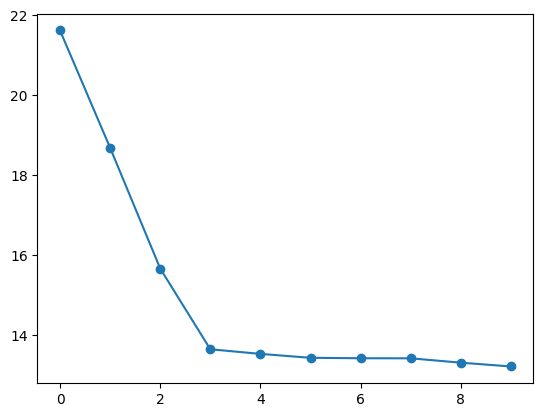

In [54]:
plt.plot(train_losses, "-o")
plt.show()

In [63]:
acc = accuracy_score(Model, test_labels)
print("Accuracy of the mini network:", acc)

Accuracy of the mini network: 0.5


**Transfer Learning**

In [55]:
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
tokenizer_for_bert = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [56]:
def bert_tokens_generator (question, passage, max_len =  794):
  input_ids = tokenizer_for_bert.encode ( question, passage,  max_length= max_len, truncation= True)   
  cls_index = input_ids.index(102)
  len_question = cls_index + 1    
  len_answer = len(input_ids)- len_question  
  segment_ids =  [0]*len_question + [1]*(len_answer)  
  
  tokens = tokenizer_for_bert.convert_ids_to_tokens(input_ids) 
  return tokens

In [57]:
def bert_ChatBot(question, passage, max_len =  512):
  input_ids = tokenizer_for_bert.encode ( question, passage,  max_length= max_len, truncation= True)   
  cls_index = input_ids.index(102)
  len_question = cls_index + 1    
  len_answer = len(input_ids)- len_question  
  segment_ids =  [0]*len_question + [1]*(len_answer)  
  
  tokens = tokenizer_for_bert.convert_ids_to_tokens(input_ids) 
    
  start_token_scores = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]) )[0]
  end_token_scores = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]) )[1]

  start_token_scores = start_token_scores.detach().numpy().flatten()
  end_token_scores = end_token_scores.detach().numpy().flatten()
    
  answer_start_index = np.argmax(start_token_scores)
  answer_end_index = np.argmax(end_token_scores)

  start_token_score = np.round(start_token_scores[answer_start_index], 2)
  end_token_score = np.round(end_token_scores[answer_end_index], 2)
    
  answer = tokens[answer_start_index] 
  for i in range(answer_start_index + 1, answer_end_index + 1):
    if tokens[i][0:2] == '##': 
      answer += tokens[i][2:] 
    else:
      answer += ' ' + tokens[i]  
  if (answer_start_index == 0) or (start_token_score < 0 ) or  (answer == '[SEP]') or ( answer_end_index <  answer_start_index):
        answer = "Sorry!, I could not find  an answer in the passage."
    
  return (answer_start_index, answer_end_index, start_token_score, end_token_score,  answer)

In [58]:
print("Tokens Generated By Bert for a specific question: ")
bert_tokens_generator("What is the name of the Institution?", training_dataset.__getitem__()) 

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Tokens Generated By Bert for a specific question: 


['[CLS]',
 'what',
 'is',
 'the',
 'name',
 'of',
 'the',
 'institution',
 '?',
 '[SEP]',
 'drag',
 '##omi',
 '##r',
 'ra',
 '##dev',
 ',',
 'the',
 'a',
 '.',
 'bartlett',
 'gia',
 '##mat',
 '##ti',
 'professor',
 'of',
 'computer',
 'science',
 ',',
 'and',
 'a',
 'beloved',
 'member',
 'of',
 'the',
 'seas',
 'community',
 ',',
 'has',
 'passed',
 'away',
 '.',
 'a',
 'celebrated',
 'scholar',
 'on',
 'many',
 'subjects',
 ',',
 'ra',
 '##dev',
 'joined',
 'the',
 'yale',
 'faculty',
 'in',
 '2017',
 'after',
 'years',
 'of',
 'accomplishments',
 'as',
 'a',
 'professor',
 'at',
 'the',
 'university',
 'of',
 'michigan',
 '.',
 'with',
 'an',
 'over',
 '##ar',
 '##ching',
 'goal',
 'of',
 'building',
 'an',
 'infrastructure',
 'for',
 'computers',
 'and',
 'humans',
 'to',
 'interact',
 'in',
 'a',
 'fluent',
 'and',
 'natural',
 'way',
 ',',
 'ra',
 '##dev',
 'led',
 'novel',
 'research',
 'projects',
 'with',
 'varied',
 'experts',
 'across',
 'the',
 'yale',
 'campus',
 ',',
 'in

In [59]:
answers=[]
print("Hi I'm ChatBot I'm Here to answer your Questions \n")
Question = input("Enter your question for me (Enter quit to exit): ")
Counter = 0
while Counter < 10:
  if Question == "quit":
    print("\nThanks for chatting with me. See you soon with more Questions!!!")
    break
  else:
    _, _ , _ , _, ans  = bert_ChatBot(Question, training_dataset.__getitem__())
    print('\nChatBot Answer: ', ans ,  '\n')
    Question = input("Enter your question for me (Enter quit to exit): ")
    answers.append(ans)

Hi I'm ChatBot I'm Here to answer your Questions 

Enter your question for me (Enter quit to exit): What is the name of the university?


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



ChatBot Answer:  university of michigan 

Enter your question for me (Enter quit to exit): Name of the professor?


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



ChatBot Answer:  dragomir radev 

Enter your question for me (Enter quit to exit): Which department was handled by dragoman Radev?


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



ChatBot Answer:  computer science 

Enter your question for me (Enter quit to exit): Breaking news in India?


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



ChatBot Answer:  Sorry!, I could not find  an answer in the passage. 

Enter your question for me (Enter quit to exit): quit

Thanks for chatting with me. See you soon with more Questions!!!


In [62]:
count = 0
for i in answers:
  if i == "Sorry!, I could not find  an answer in the passage.":
    count = count+1
print("Accuracy Of the ChatBot:", 1-(count/len(answers)))

Accuracy Of the ChatBot: 0.75
